In [1]:
import torch
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import numpy as np
import os, json, cv2, random
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from matplotlib import pyplot as plt
import os
from matplotlib.image import imread
import scipy.misc
from PIL import Image
import xml.etree.ElementTree as xml

C:\Users\Kenneth\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def comparison(inputimg, pred, titles=None):
    if titles == None:
        titles = ['Input Image', 'Prediction']
        
    fig, ax = plt.subplots(1, 2, figsize=(17, 17))
    ax[0].set_title(titles[0])
    if len(inputimg.shape) == 2:
        ax[0].imshow(inputimg, cmap='gray')
    else:
        ax[0].matshow(inputimg)
    ax[0].axis('off')


    ax[1].set_title(titles[1])
    if len(pred.shape) == 2:
        ax[1].imshow(pred, cmap='gray')
    else:
        ax[1].matshow(pred)
    ax[1].axis('off')
    plt.show()

In [3]:
def cropper(org_image_path, mask_array, out_file_name):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    img = cv2.imread(str(org_image_path))
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)
    im = Image.fromarray(output)
    im.save(out_file_name)

In [4]:
#Get the input file from a folder
path = "./images"
dir_list = os.listdir(path)
input_imagelst = list(dir_list)
input_imagelst


['input4.jpg', 'input5.jpg', 'input6.jpg']

In [5]:
# Label Name
input_label_name = input("Please Enter the image's label name:")

Please Enter the image's label name: Shell


Folder Created!
[04/18 14:44:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


C:\Users\Kenneth\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


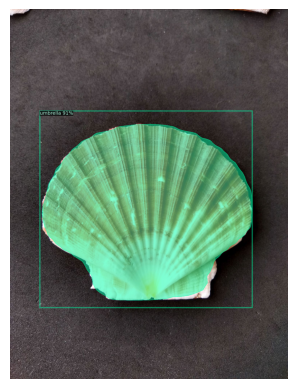

[04/18 14:44:28 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


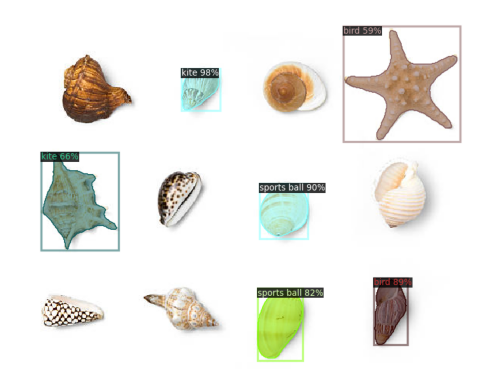

[04/18 14:44:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


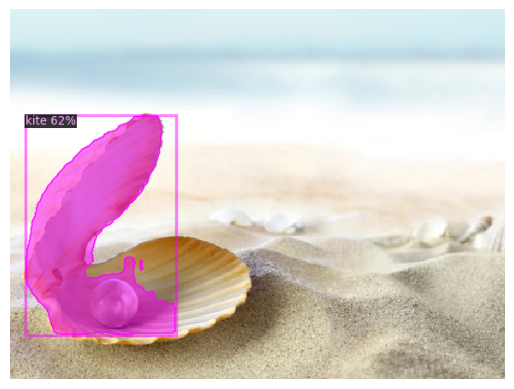

In [6]:
# Create FOLDER
try:
    os.mkdir('default')
    os.mkdir('default/Masks')
    print("Folder Created!")
except:
    print("Folder already Exist!")


for image in range(len(input_imagelst)):
    img_file = input_imagelst[image]
    img_loc = "images/" + img_file
    im = cv2.imread(img_loc)
    RGB_img = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    cfg = get_cfg()
    cfg.MODEL.DEVICE = "cpu"
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    outputs = predictor(RGB_img)
    v = Visualizer(RGB_img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1]);
    f2 = (out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

    #Cropper
    arr_masks = outputs["instances"].pred_masks.numpy()
    strsplit = img_file.split(".")
    maskname = strsplit[0] + "_mask_1.png"
    out_file_name =  "default/Masks/" + maskname
    cropper(img_loc,arr_masks,out_file_name)
    
    ####################### Exporting file ############################
    #Image height and width
    dimensions = RGB_img.shape
    dimensions
    arr_outpt = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    
    ####### VARIABLES ########

    img_height = str(dimensions[0])
    img_width = str(dimensions[1])
    detected_name = input_label_name

    root = xml.Element("annotation")
    e1 = xml.Element("filename")
    listid = [] + list(range(len(outputs["instances"].pred_boxes)))

    #IMPORTANT
    e1.text = img_file
    root.append(e1)
    e2 = xml.Element("folder")
    root.append(e2)
    e3 = xml.Element("source")
    root.append(e3)
    se1 = xml.SubElement(e3, "sourceImage")
    se2 = xml.SubElement(e3, "sourceAnnotation")
    se2.text = "Datumaro"

    #image size
    e4 = xml.Element("imagesize")
    root.append(e4)

    se3 = xml.SubElement(e4, "nrows")
    se3.text = img_height
    se4 = xml.SubElement(e4, "ncols")
    se4.text = img_width

    #!important Looping should happen here
    for i in range(len(outputs["instances"].pred_boxes)):
        e5 = xml.Element("object")
        root.append(e5)
        se5 = xml.SubElement(e5, "name")
        se5.text = detected_name
        se6 = xml.SubElement(e5, "deleted")
        se7 = xml.SubElement(e5, "verified")
        se8 = xml.SubElement(e5, "occluded")
        se8.text = "no"
        se9 = xml.SubElement(e5, "date")
        se10 = xml.SubElement(e5, "id")
        se10.text = str(listid[i])
        e6 = xml.Element("parts")
        e5.append(e6)
        se11 = xml.SubElement(e6, "hasparts")
        se12 = xml.SubElement(e6, "ispartof")

        se13 = xml.SubElement(e5, "type")
        se13.text = "bounding_box"
        e7 = xml.Element("polygon")
        e5.append(e7)
        e8 = xml.Element("pt")
        e7.append(e8)
        se14 = xml.SubElement(e8, "x")
        #x1
        se14.text = str(arr_outpt[i][0])
        se15 = xml.SubElement(e8, "y")
        #y1
        se15.text = str(arr_outpt[i][1])

        e8 = xml.Element("pt")
        e7.append(e8)
        se16 = xml.SubElement(e8, "x")
        #x2
        se16.text = str(arr_outpt[i][2])
        se17 = xml.SubElement(e8, "y")
        #y1
        se17.text = str(arr_outpt[i][1])

        e8 = xml.Element("pt")
        e7.append(e8)
        se16 = xml.SubElement(e8, "x")
        #x2
        se16.text = str(arr_outpt[i][2])
        se17 = xml.SubElement(e8, "y")
        #y2
        se17.text = str(arr_outpt[i][3])

        e8 = xml.Element("pt")
        e7.append(e8)
        se16 = xml.SubElement(e8, "x")
        #x1
        se16.text = str(arr_outpt[i][0])
        se17 = xml.SubElement(e8, "y")
        #y2
        se17.text = str(arr_outpt[i][3])
    
    
    e9 = xml.Element("username")
    e7.append(e9)

    se18 = xml.SubElement(e5,"attributes")
    se18.text = "rotation=0.0"
    ##############################################################################


    #################################################### MASK SEGMENTATION ##############
    e10 = xml.Element("object")
    root.append(e10)
    se19 = xml.SubElement(e10, "name")
    se19.text = input_label_name
    se20 = xml.SubElement(e10, "deleted")
    se21 = xml.SubElement(e10, "verified")
    se22 = xml.SubElement(e10, "occluded")
    se22.text = "no"
    se23 = xml.SubElement(e10, "date")

    #!important to change this
    se24 = xml.SubElement(e10, "id")
    se24.text = "1"

    e11 = xml.Element("parts")
    e10.append(e11)
    se25 = xml.SubElement(e11, "hasparts")
    se26 = xml.SubElement(e11, "ispartof")

    e12 = xml.Element("segm")
    e10.append(e12)
    # IMPORTANT
    se27 = xml.SubElement(e12, "mask")
    se27.text = maskname
    se27 = xml.SubElement(e12, "username")

    se28 = xml.SubElement(e10, "attributes")

    tree = xml.ElementTree(root)
    xml.indent(tree, '  ')

    xmlfilename = "default/" + strsplit[0] + ".xml"
    with open (xmlfilename, "wb") as files :
        tree.write(files)